In [31]:
import json
from pathlib import Path
from typing import Dict, Any, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math, random, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F

In [32]:
import webdataset as wds, json

REQUIRED_LANGS = ["en","fr","es","pt","zh","ar","ja","it","de"]

def txt(sample, name):
    b = sample.get(name)
    return b.decode("utf-8") if isinstance(b, (bytes, bytearray)) else ""

def show_sample(sample, max_len=80):
    meta = json.loads(sample["json"].decode("utf-8"))
    url = meta["url"]
    print("\nURL:", url)
    for lang in REQUIRED_LANGS:
        cap = txt(sample, f"cap_best_{lang}.txt")
        print(f"  {lang}: {cap[:max_len].replace('\\n',' ')}")

# Cambia il pattern se vuoi val/test
urls = "webdataset/full/shard-{00000..99999}.tar"

ds = (wds.WebDataset(urls, shardshuffle=False)
      .select(lambda s: "jpg" in s and "json" in s))

for i, sample in enumerate(ds):
    show_sample(sample)
    if i >= 4:  # mostra i primi 5
        break



URL: https://upload.wikimedia.org/wikipedia/commons/b/b6/Hawaiianislandchain_USGS.png
  en: Northwestern Hawaiian Islands
  fr: Carte de l'archipel d'Hawaï avec la distinction entre les îles du Sud-Est (South
  es: El archipiélago de Hawái.
  pt: Mapa do Arquipélago do Havaí, uma cadeia de ilhas que se estendem 2 400 km em um
  zh: 夏威夷群岛
  ar: أرخبيل هاواي
  ja: ハワイ諸島。西端がクレ環礁。その東隣のミッドウェー島のみはハワイ州に属さない。
  it: Mappa che mostra la localizzazione dei  Gardner Pinnacles nell'arcipelago delle 
  de: Karte der Hawaii-Inseln

URL: https://upload.wikimedia.org/wikipedia/commons/5/58/Anguilla_anguilla.jpg
  en: The European eel was named Muraena angvilla in 1758.
  fr: Anguille européenne.
  es: Anguila (Anguilla anguilla).
  pt: A enguia-europeia
  zh: 欧洲鳗鲡
（Anguilla anguilla）
  ar: الإنقليس الأوروبي (Anguilla anguilla)، أحد التفسيرات لماهية وحش البحيرة المزعوم.
  ja: ヨーロッパ産 Anguilla anguilla
  it: L'anguilla, per lungo tempo simbolo dell'economia locale
  de: Europäischer Aal (Anguilla anguill

In [33]:
import glob, os

counts = {}
seen_overall = set()

for path in glob.glob('state/*_done.txt'):
    split = os.path.basename(path).replace('_done.txt', '')  # es. "train"
    seen_split = set()
    with open(path, encoding='utf-8') as f:
        for line in f:
            url = line.strip()
            if not url: 
                continue
            seen_split.add(url)
            seen_overall.add(url)
    counts[split] = len(seen_split)

# stampa ordinata per split noti (train/val/test) poi gli altri eventuali
for split in ['train', 'val', 'test']:
    if split in counts:
        print(f'{split}: {counts[split]}')
for split in sorted(set(counts) - {'train', 'val', 'test'}):
    print(f'{split}: {counts[split]}')

print('totale_unico:', len(seen_overall))

full: 2768
totale_unico: 2768


In [34]:
# Setup
import json, os, math
from pathlib import Path
import pandas as pd
import numpy as np

REPORT_PATH = "webdataset/alignment/report_full_ar-de-en-es-fr-it-ja-pt-zh.json"

with open(REPORT_PATH, "r", encoding="utf-8") as f:
    report = json.load(f)

def find_result_block(kind: str, split: str | None = None):
    for b in report["results"]:
        if b["kind"] == kind and (split is None and "split" not in b or split is not None and b.get("split")==split):
            return b
    return None

def safe_round(x, n=4):
    try: return round(float(x), n)
    except: return x


In [35]:
# Macro risultati (train / holdout / eval splits)
rows = []
for b in report["results"]:
    label = b["kind"] if "split" not in b else f'{b["kind"]}:{b["split"]}'
    mac = b["macro_avg"]
    rows.append({
        "block": label,
        "n_pairs": b["n_pairs"],
        "R@1_before": mac["before"]["R@1"],
        "R@1_after":  mac["after"]["R@1"],
        "Δ R@1":      mac["delta"]["R@1"],
        "R@5_before": mac["before"]["R@5"],
        "R@5_after":  mac["after"]["R@5"],
        "Δ R@5":      mac["delta"]["R@5"],
        "R@10_before": mac["before"]["R@10"],
        "R@10_after":  mac["after"]["R@10"],
        "Δ R@10":      mac["delta"]["R@10"],
        "mAP_before": mac["before"]["mAP"],
        "mAP_after":  mac["after"]["mAP"],
        "Δ mAP":      mac["delta"]["mAP"],
    })
df_macro = pd.DataFrame(rows)
df_macro = df_macro.sort_values(by="block").reset_index(drop=True)
df_macro.style.format({c: "{:.4f}" for c in df_macro.columns if c not in ["block","n_pairs"]})


,block,n_pairs,R@1_before,R@1_after,Δ R@1,R@5_before,R@5_after,Δ R@5,R@10_before,R@10_after,Δ R@10,mAP_before,mAP_after,Δ mAP
0,holdout:holdout,554,0.4647,0.4866,0.0219,0.7166,0.7367,0.0201,0.7996,0.8147,0.0150,0.5797,0.5999,0.0202
1,train,2214,0.3164,0.3445,0.0282,0.5644,0.5956,0.0312,0.6580,0.6854,0.0274,0.4327,0.4612,0.0284


In [36]:
# Per-lingua (train): tabella ordinata per miglioramento Δ R@1
train_block = find_result_block("train")
pl_before = pd.DataFrame(train_block["per_lang"]["before"]).T
pl_after  = pd.DataFrame(train_block["per_lang"]["after"]).T
pl_delta  = pd.DataFrame(train_block["per_lang"]["delta"]).T

per_lang_train = (
    pl_before.add_suffix("_before")
    .join(pl_after.add_suffix("_after"))
    .join(pl_delta.add_prefix("Δ "))
    .sort_values(by="Δ R@1", ascending=False)
)
per_lang_train.index.name = "lang"
per_lang_train.style.format("{:.4f}")


,R@1_before,R@5_before,R@10_before,mAP_before,R@1_after,R@5_after,R@10_after,mAP_after,Δ R@1,Δ R@5,Δ R@10,Δ mAP
lang,,,,,,,,,,,,
de,0.3288,0.5998,0.6870,0.4525,0.3654,0.6287,0.7100,0.4875,0.0366,0.0289,0.0230,0.0350
fr,0.3433,0.6007,0.6996,0.4639,0.3771,0.6238,0.7213,0.4941,0.0339,0.0230,0.0217,0.0302
ar,0.1983,0.4006,0.4905,0.2984,0.2285,0.4386,0.5257,0.3299,0.0303,0.0379,0.0352,0.0315
pt,0.3618,0.6161,0.7114,0.4790,0.3921,0.6450,0.7335,0.5087,0.0303,0.0289,0.0221,0.0296
it,0.3455,0.6021,0.6856,0.4652,0.3744,0.6387,0.7182,0.4934,0.0289,0.0366,0.0325,0.0282
es,0.3582,0.6174,0.7046,0.4757,0.3848,0.6405,0.7236,0.5022,0.0266,0.0230,0.0190,0.0265
en,0.4250,0.7082,0.7895,0.5526,0.4503,0.7254,0.8017,0.5740,0.0253,0.0172,0.0122,0.0214
ja,0.2168,0.4300,0.5375,0.3237,0.2407,0.4783,0.5890,0.3539,0.0239,0.0483,0.0515,0.0302
zh,0.2696,0.5045,0.6165,0.3834,0.2873,0.5416,0.6454,0.4067,0.0176,0.0370,0.0289,0.0233


In [37]:
# Holdout (se presente) e eventuali eval split
holdout_block = find_result_block("holdout", split="holdout")
if holdout_block is not None:
    plb = pd.DataFrame(holdout_block["per_lang"]["before"]).T
    pla = pd.DataFrame(holdout_block["per_lang"]["after"]).T
    pld = pd.DataFrame(holdout_block["per_lang"]["delta"]).T
    per_lang_holdout = (
        plb.add_suffix("_before")
        .join(pla.add_suffix("_after"))
        .join(pld.add_prefix("Δ "))
        .sort_values(by="Δ R@1", ascending=False)
    )
    display(per_lang_holdout.style.format("{:.4f}"))
else:
    print("Nessun blocco holdout nel report.")

# Eval splits (se esistono)
eval_blocks = [b for b in report["results"] if b["kind"]=="eval"]
for b in eval_blocks:
    print(f"\n== Eval split: {b['split']} ==")
    plb = pd.DataFrame(b["per_lang"]["before"]).T
    pla = pd.DataFrame(b["per_lang"]["after"]).T
    pld = pd.DataFrame(b["per_lang"]["delta"]).T
    per_lang_eval = (
        plb.add_suffix("_before")
        .join(pla.add_suffix("_after"))
        .join(pld.add_prefix("Δ "))
        .sort_values(by="Δ R@1", ascending=False)
    )
    display(per_lang_eval.style.format("{:.4f}"))


,R@1_before,R@5_before,R@10_before,mAP_before,R@1_after,R@5_after,R@10_after,mAP_after,Δ R@1,Δ R@5,Δ R@10,Δ mAP
ar,0.3231,0.5830,0.6769,0.4422,0.3773,0.6119,0.6949,0.4879,0.0542,0.0289,0.0181,0.0457
zh,0.4188,0.6859,0.7708,0.5404,0.4495,0.6949,0.7816,0.5614,0.0307,0.0090,0.0108,0.0210
it,0.4693,0.7310,0.8213,0.5946,0.4964,0.7437,0.8466,0.6129,0.0271,0.0126,0.0253,0.0183
fr,0.5108,0.7437,0.7996,0.6176,0.5361,0.7455,0.8087,0.6323,0.0253,0.0018,0.0090,0.0148
pt,0.5072,0.7690,0.8574,0.6239,0.5253,0.7744,0.8682,0.6411,0.0181,0.0054,0.0108,0.0172
ja,0.3502,0.6119,0.7166,0.4700,0.3682,0.6588,0.7310,0.4960,0.0181,0.0469,0.0144,0.0260
es,0.5054,0.7653,0.8484,0.6205,0.5217,0.7888,0.8646,0.6383,0.0162,0.0235,0.0162,0.0178
de,0.4765,0.7347,0.8105,0.5966,0.4819,0.7617,0.8394,0.6103,0.0054,0.0271,0.0289,0.0138
en,0.6209,0.8249,0.8953,0.7114,0.6227,0.8502,0.8971,0.7190,0.0018,0.0253,0.0018,0.0076


In [38]:
# Diagnostiche (train): macro + per-lingua
diag_train = report["diagnostics"]["train"]
macro_before = pd.DataFrame([diag_train["before"]["macro_avg"]], index=["before"]).T
macro_after  = pd.DataFrame([diag_train["after"]["macro_avg"]], index=["after"]).T
macro_delta  = pd.DataFrame([diag_train["delta_macro"]], index=["Δ"]).T
diag_macro = pd.concat([macro_before, macro_after, macro_delta], axis=1)
diag_macro.columns = ["before","after","Δ"]
display(diag_macro.style.format("{:.4f}"))

# per-lingua
diag_pl_before = pd.DataFrame(diag_train["before"]["per_lang"]).T
diag_pl_after  = pd.DataFrame(diag_train["after"]["per_lang"]).T
diag_pl_delta  = diag_pl_after - diag_pl_before
diag_pl = (
    diag_pl_before.add_suffix("_before")
    .join(diag_pl_after.add_suffix("_after"))
    .join(diag_pl_delta.add_prefix("Δ "))
    .sort_values(by="Δ effective_rank", ascending=False)
)
display(diag_pl.style.format("{:.4f}"))

# Gram correlation riassunta
print("Gram corr mean — before:", safe_round(diag_train["before"]["gram_corr_mean"], 4),
      "| after:", safe_round(diag_train["after"]["gram_corr_mean"], 4))


,before,after,Δ
effective_rank,136.6424,130.7487,-5.8937
pca90_components,195.3333,190.3333,-5.0000
mean_pairwise_cosine,0.6599,0.6211,-0.0388
PoZ,0.0362,0.0356,-0.0006
entropy,0.7472,0.7817,0.0345


,effective_rank_before,pca90_components_before,mean_pairwise_cosine_before,PoZ_before,entropy_before,effective_rank_after,pca90_components_after,mean_pairwise_cosine_after,PoZ_after,entropy_after,Δ effective_rank,Δ pca90_components,Δ mean_pairwise_cosine,Δ PoZ,Δ entropy
ar,119.8319,182.0000,0.7358,0.0434,0.7149,116.4663,177.0000,0.7060,0.0427,0.7478,-3.3656,-5.0000,-0.0298,-0.0007,0.0328
ja,120.6806,180.0000,0.7560,0.0436,0.7045,116.0902,175.0000,0.7281,0.0430,0.7369,-4.5904,-5.0000,-0.0280,-0.0006,0.0324
zh,127.7710,187.0000,0.7402,0.0419,0.7131,122.6167,182.0000,0.7106,0.0413,0.7451,-5.1543,-5.0000,-0.0296,-0.0006,0.0320
it,138.7174,199.0000,0.6353,0.0344,0.7580,132.5909,194.0000,0.5933,0.0337,0.7932,-6.1265,-5.0000,-0.0419,-0.0007,0.0353
de,135.7961,197.0000,0.6410,0.0342,0.7552,129.6111,192.0000,0.6000,0.0337,0.7902,-6.1850,-5.0000,-0.0409,-0.0005,0.0350
pt,143.8857,203.0000,0.6234,0.0337,0.7631,137.4395,198.0000,0.5805,0.0329,0.7983,-6.4462,-5.0000,-0.0429,-0.0008,0.0352
es,140.4694,199.0000,0.6195,0.0329,0.7641,133.9703,194.0000,0.5756,0.0327,0.8005,-6.4991,-5.0000,-0.0439,-0.0002,0.0365
fr,145.1311,201.0000,0.6353,0.0336,0.7566,138.3145,196.0000,0.5929,0.0326,0.7924,-6.8166,-5.0000,-0.0424,-0.0010,0.0358
en,157.4983,210.0000,0.5530,0.0286,0.7951,149.6387,205.0000,0.5031,0.0280,0.8308,-7.8596,-5.0000,-0.0499,-0.0006,0.0357


Gram corr mean — before: 0.3452 | after: 0.35


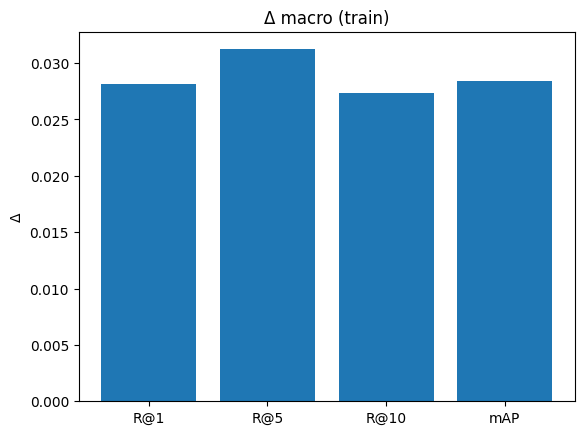

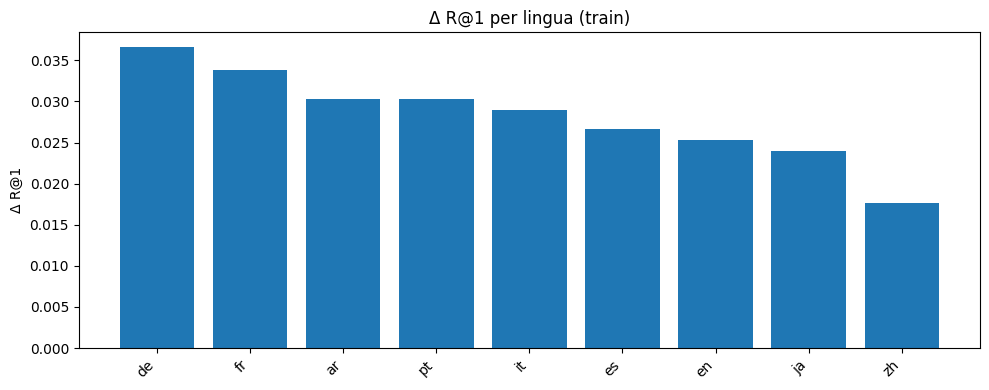

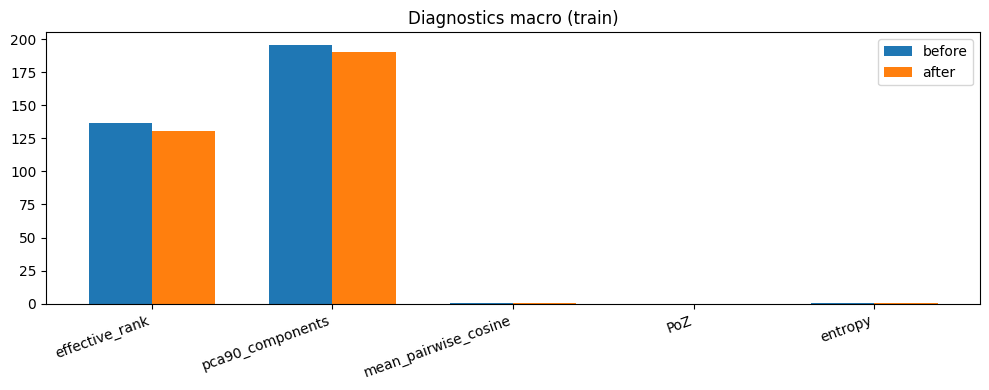

In [39]:
# Mini dashboard
import matplotlib.pyplot as plt

# 6a) Barre macro Δ (train)
cols = ["R@1","R@5","R@10","mAP"]
delta = [df_macro.loc[df_macro["block"]=="train", f"Δ {c}"].values[0] for c in cols]
plt.figure()
plt.bar(cols, delta)
plt.title("Δ macro (train)")
plt.ylabel("Δ")
plt.show()

# 6b) Δ R@1 per lingua (train)
langs = per_lang_train.index.tolist()
vals = per_lang_train["Δ R@1"].values
plt.figure(figsize=(10,4))
plt.bar(langs, vals)
plt.title("Δ R@1 per lingua (train)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Δ R@1")
plt.tight_layout()
plt.show()

# 6c) Diagnostiche macro — before/after (train)
dm = diag_macro.copy()
dm = dm.loc[["effective_rank","pca90_components","mean_pairwise_cosine","PoZ","entropy"]]
x = np.arange(len(dm.index))
w = 0.35
plt.figure(figsize=(10,4))
plt.bar(x - w/2, dm["before"].values, width=w, label="before")
plt.bar(x + w/2, dm["after"].values,  width=w, label="after")
plt.xticks(x, dm.index, rotation=20, ha="right")
plt.title("Diagnostics macro (train)")
plt.legend()
plt.tight_layout()
plt.show()


In [40]:
# Check rapido qualità rappresentazionale (rule-of-thumb)
rules = []
er = diag_macro.loc["effective_rank", "after"]
poz = diag_macro.loc["PoZ", "after"]
iso = diag_macro.loc["mean_pairwise_cosine", "after"]

rules.append(("Effective Rank", er, "buono" if er > diag_macro.loc["effective_rank","before"] else "stabile/↓"))
rules.append(("PoZ (↓ meglio)", poz, "buono" if poz < diag_macro.loc["PoZ","before"] else "peggiorato"))
rules.append(("Isotropy proxy (|μ cos| ↓ meglio)", iso, "buono" if abs(iso) < abs(diag_macro.loc["mean_pairwise_cosine","before"]) else "peggiorato"))

summary = pd.DataFrame(rules, columns=["metrica","valore_after","giudizio"])
summary

,metrica,valore_after,giudizio
0,Effective Rank,130.748689,stabile/↓
1,PoZ (↓ meglio),0.035625,buono
2,Isotropy proxy (|μ cos| ↓ meglio),0.621119,buono


In [41]:
# Generalization gap: (train_after - holdout_after) e (train_delta - holdout_delta)
import pandas as pd

train_row   = df_macro[df_macro["block"]=="train"].iloc[0]
hold_row    = df_macro[df_macro["block"]=="holdout:holdout"].iloc[0]

gap = pd.Series({
    "R@1_after_gap":  train_row["R@1_after"]  - hold_row["R@1_after"],
    "R@5_after_gap":  train_row["R@5_after"]  - hold_row["R@5_after"],
    "R@10_after_gap": train_row["R@10_after"] - hold_row["R@10_after"],
    "mAP_after_gap":  train_row["mAP_after"]  - hold_row["mAP_after"],
    "ΔR@1_gap":       train_row["Δ R@1"]      - hold_row["Δ R@1"],
    "ΔR@5_gap":       train_row["Δ R@5"]      - hold_row["Δ R@5"],
    "ΔR@10_gap":      train_row["Δ R@10"]     - hold_row["Δ R@10"],
    "ΔmAP_gap":       train_row["Δ mAP"]      - hold_row["Δ mAP"],
})
gap.to_frame("value")


,value
R@1_after_gap,-0.142037
R@5_after_gap,-0.141059
R@10_after_gap,-0.129295
mAP_after_gap,-0.138761
ΔR@1_gap,0.006293
ΔR@5_gap,0.011159
ΔR@10_gap,0.012309
ΔmAP_gap,0.008212


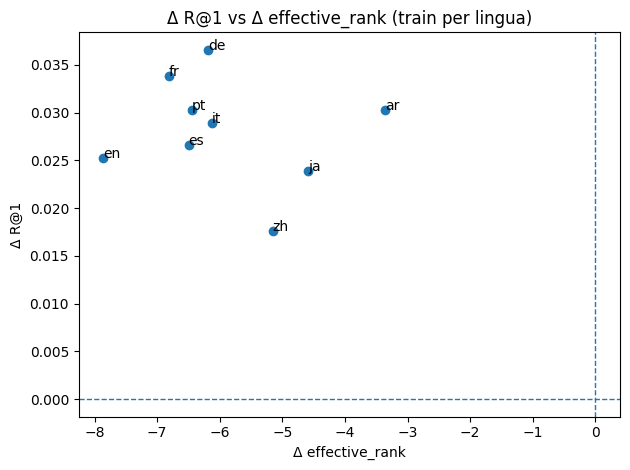

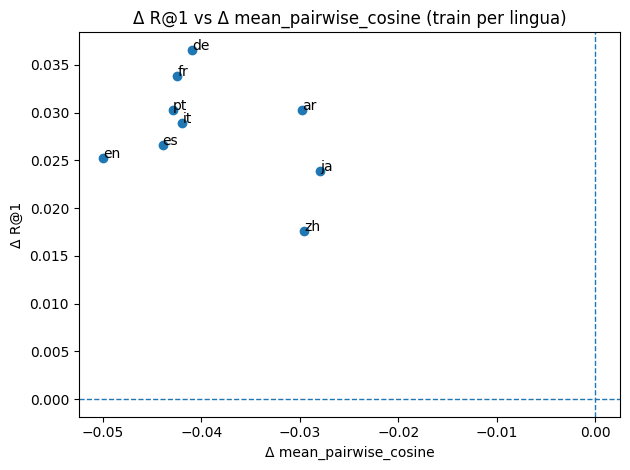

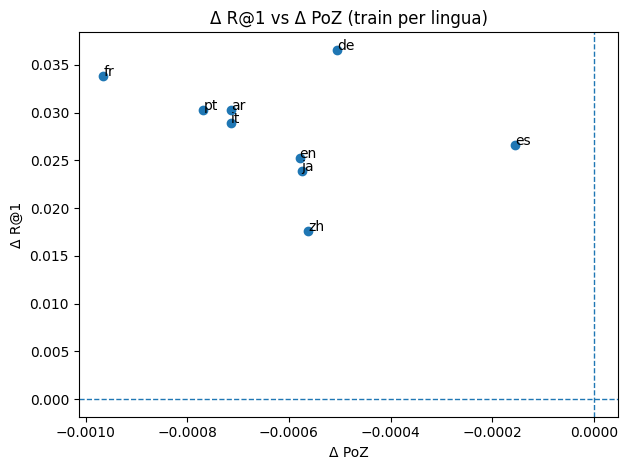

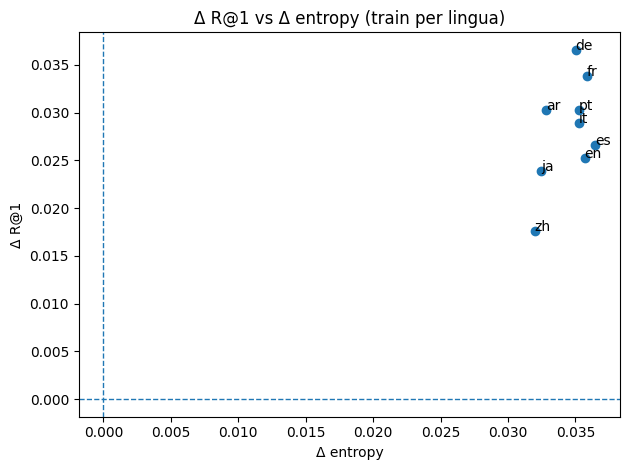

,Δ effective_rank,Δ mean_pairwise_cosine,Δ PoZ,Δ entropy,Δ R@1
Δ effective_rank,1.000000,0.919750,-0.046369,-0.808914,-0.175508
Δ mean_pairwise_cosine,0.919750,1.000000,-0.054978,-0.931701,-0.385329
Δ PoZ,-0.046369,-0.054978,1.000000,0.103214,-0.320738
Δ entropy,-0.808914,-0.931701,0.103214,1.000000,0.532809
Δ R@1,-0.175508,-0.385329,-0.320738,0.532809,1.000000


In [42]:
import matplotlib.pyplot as plt

# Per-lingua train (già costruito come per_lang_train)
diag_train = report["diagnostics"]["train"]
D0 = pd.DataFrame(diag_train["before"]["per_lang"]).T.add_suffix("_before")
D1 = pd.DataFrame(diag_train["after"]["per_lang"]).T.add_suffix("_after")
D  = D0.join(D1)
D["Δ effective_rank"] = D["effective_rank_after"] - D["effective_rank_before"]
D["Δ mean_pairwise_cosine"] = D["mean_pairwise_cosine_after"] - D["mean_pairwise_cosine_before"]
D["Δ PoZ"] = D["PoZ_after"] - D["PoZ_before"]
D["Δ entropy"] = D["entropy_after"] - D["entropy_before"]

E = per_lang_train.join(D[["Δ effective_rank","Δ mean_pairwise_cosine","Δ PoZ","Δ entropy"]])

pairs = [
    ("Δ effective_rank", "Δ R@1"),
    ("Δ mean_pairwise_cosine", "Δ R@1"),
    ("Δ PoZ", "Δ R@1"),
    ("Δ entropy", "Δ R@1"),
]

for x, y in pairs:
    plt.figure()
    plt.scatter(E[x], E[y])
    for i, lang in enumerate(E.index.tolist()):
        plt.text(E[x].iloc[i], E[y].iloc[i], lang)
    plt.axhline(0, ls="--", lw=1)
    plt.axvline(0, ls="--", lw=1)
    plt.xlabel(x); plt.ylabel(y); plt.title(f"{y} vs {x} (train per lingua)")
    plt.tight_layout()
    plt.show()

E[[c for c in ["Δ effective_rank","Δ mean_pairwise_cosine","Δ PoZ","Δ entropy","Δ R@1"]]].corr()